In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForSequenceClassification, BertTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from torch.optim import AdamW
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

In [ ]:
# Configurar dispositivo para GPU si está disponible
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'Usando el dispositivo: {device}')

Usando el dispositivo: cuda:0


In [ ]:
# Cargar el modelo y el tokenizador pre-entrenado
model = BertForSequenceClassification.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", num_labels=5)  # 7 clases
tokenizer = BertTokenizer.from_pretrained("dccuchile/bert-base-spanish-wwm-cased", do_lower_case=False)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Mover el modelo a la GPU si está disponible
model.to(device='cuda:0')

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31002, 768, padding_idx=1)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

PREPARACION DE LOS DATOS

In [ ]:
# seleccionamos el arhchivo datos_editados_18.95.csv

from google.colab import files

# Cargar el archivo desde el sistema local
uploaded = files.upload()

# Obtener el nombre del archivo cargado
file_name = list(uploaded.keys())[0]

# Listar los archivos en el directorio actual
!ls

# Obtener la ruta del archivo en el sistema de archivos de Colab
import os
current_directory = os.getcwd()
file_path = os.path.join(current_directory, file_name)
print("Ruta del archivo:", file_path)

Saving datos_tfm.csv to datos_tfm.csv
datos_tfm.csv  sample_data
Ruta del archivo: /content/datos_tfm.csv


In [ ]:
datos_editados = pd.read_csv("datos_tfm.csv",encoding='latin1') # estos datos los hemos extraido de manera previa uniendo la variable "4"="CAOS" para ver si tenían mas relacion

In [ ]:
print(len(datos_editados)) #1138

1388


In [ ]:
print(datos_editados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1388 entries, 0 to 1387
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Frase        1388 non-null   object
 1   Consensuada  1388 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.8+ KB
None


In [ ]:
print(datos_editados.columns)

Index(['Frase', 'Consensuada'], dtype='object')


In [ ]:
import plotly.graph_objects as go
# Diccionario para mapear valores a estilos
value_to_style = {
    0: 'Estilo sin identificar',
    1: 'Apoyo a la autonomía',
    2: 'Estructura',
    3: 'Control',
    4: 'Caos'
}

# Crear una lista de colores
colors = {
    'Estilo sin identificar': 'lightblue',
    'Apoyo a la autonomía': 'lightgreen',
    'Estructura': 'lightcoral',
    'Control': 'plum',
    'Caos': 'peachpuff'
}

# Crear las barras del gráfico
bars = []
for value, row in frequency.iterrows():
    style = value_to_style[row['Value']]
    bars.append(go.Bar(
        x=[row['Value']],
        y=[row['Frequency']],
        name=style,
        marker_color=colors[style]
    ))

# Crear el gráfico
fig = go.Figure(data=bars)

# Actualizar el layout del gráfico
fig.update_layout(
    title={
        'text': 'Frecuencia de cada valor en la variable',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis_title='Valor',
    yaxis_title='Frecuencia',
    barmode='group',
    width=900,  # Ancho del gráfico
    height=800  # Alto del gráfico
)

# Mostrar el gráfico
fig.show()

NameError: name 'frequency' is not defined

In [ ]:
# En los datos de entrenamiento tendría que haber informacion suficiente para entrenar de todas las variables ( a destacar la variable 4 (CAOS))
train_texts, test_texts, train_labels, test_labels = train_test_split(datos_editados['Frase'], datos_editados['Consensuada'], test_size=0.25, random_state=42,stratify=datos_editados['Consensuada'] )


In [ ]:
y = datos_editados.Consensuada

In [ ]:
# RECUENTO POR CADA CLASE de la variable "Consensuada"
unique, counts = np.unique(y, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TOTAL %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TOTAL 0: Samples 275
Consensuada TOTAL 1: Samples 290
Consensuada TOTAL 2: Samples 456
Consensuada TOTAL 3: Samples 196
Consensuada TOTAL 4: Samples 171


In [ ]:
# RECUENTO EN LOS DATOS DE ENTRENAMIENTO
unique, counts = np.unique(train_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TRAIN %i: Samples %i' % (unique[i], counts[i]) )


Consensuada TRAIN 0: Samples 206
Consensuada TRAIN 1: Samples 218
Consensuada TRAIN 2: Samples 342
Consensuada TRAIN 3: Samples 147
Consensuada TRAIN 4: Samples 128


In [ ]:
# Veamos ahora el recuento en los DATOS DE TEST
# Number of samples per class
unique, counts = np.unique(test_labels, return_counts=True)
for i in range(0,len(unique)):
  print('Consensuada TEST %i: Samples %i' % (unique[i], counts[i]) )
# efectivamente está mal porque

Consensuada TEST 0: Samples 69
Consensuada TEST 1: Samples 72
Consensuada TEST 2: Samples 114
Consensuada TEST 3: Samples 49
Consensuada TEST 4: Samples 43


In [ ]:
!pip install transformers

In [ ]:
# Calcular la longitud promedio de las frases en train_texts
lengths = [len(text.split()) for text in train_texts.tolist()]
avg_length = np.mean(lengths)
print(f"Longitud promedio de las frases: {avg_length:.2f}")

Longitud promedio de las frases: 14.99


In [ ]:
# Tokenización y creación de datasets
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True,max_length=20)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True,max_length=20)

In [ ]:
train_labels = torch.tensor(train_labels.tolist()).to(device='cuda:0')
test_labels = torch.tensor(test_labels.tolist()).to(device='cuda:0')

## Convertimos ahora los datos a tensores de PyTorch

In [ ]:
train_dataset = torch.utils.data.TensorDataset(
    torch.tensor(train_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(train_encodings['attention_mask']).to(device='cuda:0'),
    train_labels
)

In [ ]:
test_dataset = torch.utils.data.TensorDataset(
    torch.tensor(test_encodings['input_ids']).to(device='cuda:0'),
    torch.tensor(test_encodings['attention_mask']).to(device='cuda:0'),
    test_labels
)

## Definimos el DataLoader para cargar los datos durante el entrenamiento

In [ ]:
# DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)

## Optimizador y funcion de perdida

In [ ]:
# optimizer = AdamW(model.parameters(), lr=5e-5)
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = torch.nn.CrossEntropyLoss()




```
# max_length = 512
# lr = 2e-5
# stratify=datos_editados['Consensuada']
```



In [ ]:
model.eval()
total_val_loss = 0
correct_val_predictions = 0
total_val_predictions = 0
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        total_val_loss += loss.item()

        predictions = torch.argmax(outputs.logits, dim=1)
        correct_val_predictions += (predictions == labels).sum().item()
        total_val_predictions += len(labels)

val_accuracy = correct_val_predictions / total_val_predictions
validation_loss.append(total_val_loss / len(test_dataloader))
validation_accuracy.append(val_accuracy)


In [ ]:
model.train()
for epoch in range(80):  # Cambia el número de épocas según necesites
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # Calcular las predicciones y la precisión
        predictions = torch.argmax(outputs.logits, dim=1)
        correct_predictions += (predictions == labels).sum().item()
        total_predictions += len(labels)

    # Calcular la precisión
    accuracy = correct_predictions / total_predictions

    # Imprimir los resultados después de cada época
    print(f"Epoch {epoch + 1}, Loss: {total_loss}, Accuracy: {accuracy}")



Epoch 1, Loss: 77.9728245139122, Accuracy: 0.6055979643765903
Epoch 2, Loss: 41.6683519333601, Accuracy: 0.7998303647158609
Epoch 3, Loss: 19.063807480037212, Accuracy: 0.9211195928753181
Epoch 4, Loss: 11.042441999539733, Accuracy: 0.9558948261238338
Epoch 5, Loss: 7.334707879461348, Accuracy: 0.9694656488549618
Epoch 6, Loss: 4.981031039729714, Accuracy: 0.9754028837998303
Epoch 7, Loss: 3.1700944912154227, Accuracy: 0.9847328244274809
Epoch 8, Loss: 5.026487322058529, Accuracy: 0.9745547073791349
Epoch 9, Loss: 5.411196736153215, Accuracy: 0.9762510602205259
Epoch 10, Loss: 4.396322461543605, Accuracy: 0.981340118744699
Epoch 11, Loss: 3.1216384363360703, Accuracy: 0.9847328244274809
Epoch 12, Loss: 4.939132369472645, Accuracy: 0.9770992366412213
Epoch 13, Loss: 5.353255317313597, Accuracy: 0.9754028837998303
Epoch 14, Loss: 3.801870173541829, Accuracy: 0.9804919423240034
Epoch 15, Loss: 4.007664463948458, Accuracy: 0.9745547073791349
Epoch 16, Loss: 4.259899392724037, Accuracy: 0.9

## evaluacion del conjunto de pruebas

In [ ]:
# Evaluación del modelo
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for batch in test_dataloader:
        input_ids, attention_mask, labels = batch
        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)
class_names = ['SE', 'AA', 'E', 'CON','CA']



In [ ]:
# Impresión de métricas de evaluación
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.78      0.65      0.71        69
           1       0.71      0.83      0.76        72
           2       0.86      0.89      0.87       114
           3       0.49      0.45      0.47        49
           4       0.76      0.74      0.75        43

    accuracy                           0.75       347
   macro avg       0.72      0.71      0.71       347
weighted avg       0.75      0.75      0.75       347



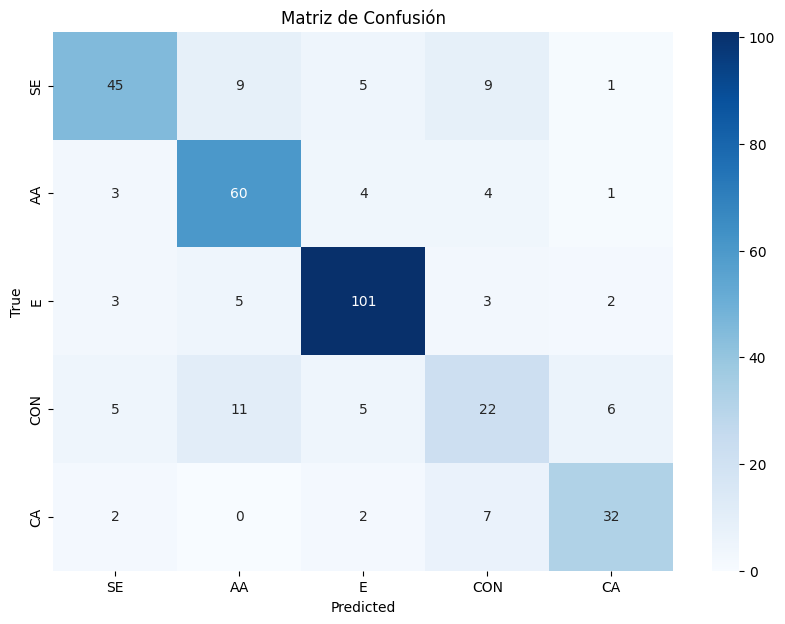

In [ ]:
# Visualizar la matriz de confusión
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()